In [1]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests 
import time

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from geopy.geocoders import Nominatim
import ast

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

# **1. Merge ``df_masters`` & ``df_ratings``**

In [2]:
# import the dataframes
df_uk_masters = pd.read_csv('Datasets/df_uk_masters.csv')                         # all the albums from the UK
df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')                         # albums from the US until 1996, 1998 and 2000
df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')                         # albums from the US from 1997, 1999 and 2001
df_masters = pd.read_csv('Datasets/df_masters.csv')
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # albums with >= 20 votes, mostly from rock, worldwide
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (and others) with >= 20 votes, until 2000 aprox

# print information
print(f'{df_uk_masters.shape}: df_uk_masters')
print(f'{df_us_masters.shape}: df_us_masters')
print(f'{df_us_new_masters.shape}: df_us_new_masters')
print(f'{df_masters.shape}: df_masters')
print(f'{df_ratings_20.shape}: df_ratings_20')
print(f'{df_masters_blended.shape}: df_masters_blended')

(56660, 13): df_uk_masters
(48690, 13): df_us_masters
(74652, 13): df_us_new_masters
(11346, 13): df_masters
(51222, 5): df_ratings_20
(9667, 13): df_masters_blended


<Axes: xlabel='count', ylabel='year'>

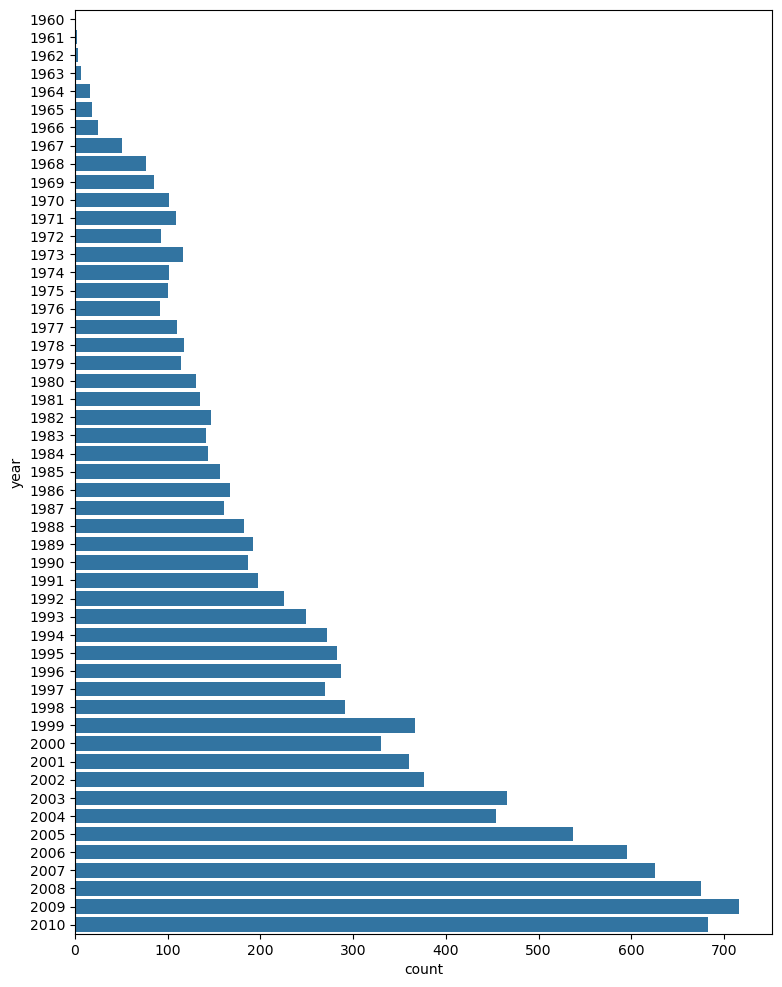

In [ ]:
plt.figure(figsize=(9,12))
sns.countplot(data=df_masters, y='year')

## **Concat with the albums previously cleaned**

In [93]:
df_us_2019 = pd.read_csv('Datasets/df_us_2019.csv')
df_us_2019.shape

(200, 13)

In [94]:
df_us_2019['year'].value_counts().head(10)

year
2019    167
2018      6
2012      5
2011      4
2017      3
2009      2
2014      2
2006      1
1990      1
2002      1
Name: count, dtype: int64

In [95]:
df_us_2019['styles'].value_counts().head(10)

styles
['Progressive Metal']                                                                    19
['Metalcore', 'Progressive Metal']                                                        8
['Technical Death Metal', 'Progressive Metal']                                            7
['Prog Rock', 'Progressive Metal']                                                        6
['Space Rock']                                                                            3
['Progressive Metal', 'Prog Rock']                                                        3
['Art Rock', 'Krautrock', 'Psychedelic Rock', 'Prog Rock', 'Space Rock', 'Folk Rock']     3
['Death Metal']                                                                           2
[]                                                                                        2
['Prog Rock']                                                                             2
Name: count, dtype: int64

In [96]:
df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')                         # albums from the US from 1997, 1999 and 2001
df_us_new_masters.shape

(18011, 13)

In [98]:
df_concat = pd.concat([df_us_new_masters, df_us_2019])
df_concat.shape

(18211, 13)

In [99]:
check_duplicates(df_concat)

Found 4 duplicates:
Resulting dataset: (18207, 13)


<Axes: xlabel='count', ylabel='year'>

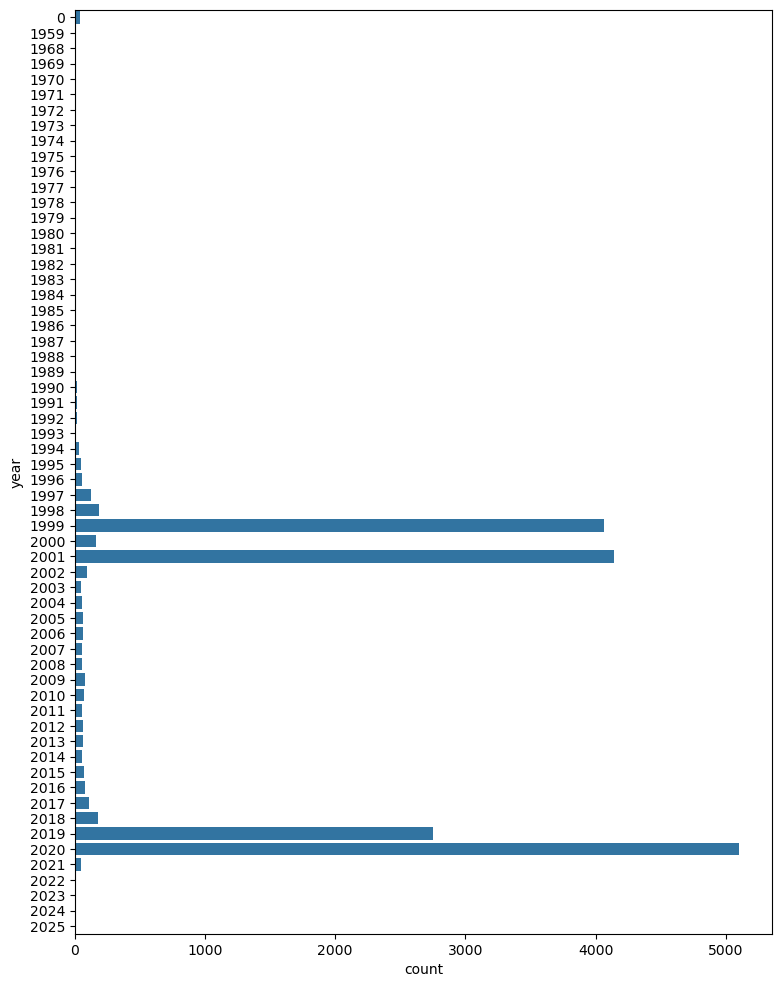

In [100]:
# make sure most of the albums are from the year I theoretically just got
plt.figure(figsize=(9,12))
sns.countplot(data=df_concat, y='year')

**Export to csv**

In [101]:
df_concat.to_csv('Datasets/df_us_new_masters.csv', index=False)

## **``df_masters`` parenthesis cleaning from ``artist``**

### Testing

I noticed that some artists in df_masters (so, in the Discogs API) have numbers in parenthesis in the artist name, which won't be merged with df_ratings, where there are almost no artists with numbers in parenthesis

In [6]:
# all the artists in df_masters
df_masters['artist'].nunique()

51793

In [7]:
# show the artists that have characters in parenthesis in the artist name
df_masters_parenthesis = df_masters[df_masters['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_masters_parenthesis['artist'].nunique()

9541

In [34]:
# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_masters_parenthesis.shape}: df_masters_parenthesis')

(15584, 13): df_masters
(656, 13): df_masters_parenthesis


In [ ]:
df_ratings_10['artist'].nunique()

23683

In [ ]:
# show the artists that have characters in parenthesis in the artist name
df_ratings_10_parenthesis = df_ratings_10[df_ratings_10['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_ratings_10_parenthesis['artist'].nunique()

0

In [ ]:
# print information
print(f'{df_ratings_10.shape}: df_ratings_10')
print(f'{df_ratings_10_parenthesis.shape}: df_ratings_10_parenthesis')

(79632, 5): df_ratings_top
(1760, 5): df_ratings_top_parenthesis


In [ ]:
df_ratings_10_parenthesis.sample(5)

,album_id,artist,title,rating,votes
66859,299052,Vacations (AUS),Vibes and Days,3.87,15
66521,293448,Carnation (BE),Chapel of Abhorrence,3.35,40
34007,67551,Soundtrack (Video Game),The Legend of Zelda: Twilight Princess OST,4.23,80
39072,84542,Doom (JPN),Complicated Mind,4.16,25
36362,74638,Tempest (Can),Passages,3.73,37


In most of the artists, the information between parenthesis is the country of origin

In [39]:
# delete these characters
df_masters_parenthesis_clean = df_masters_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_masters_parenthesis_clean

2364       100% Proof
3971       100% Proof
2622     20/20 Vision
1164       38 Special
2445       38 Special
            ...      
3727              XIT
3045            Ya Ya
1735    Youth In Asia
3931              ZED
599              Zeno
Name: artist, Length: 656, dtype: object

In [ ]:
# delete these characters
df_ratings_10_parenthesis_clean = df_ratings_10_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_ratings_10_parenthesis_clean

52533                  
53599                  
35534    Slowest Runner
35487    Slowest Runner
13266              p.e.
              ...      
39716              hide
68464              life
70926              life
49438              sway
68857              オオハシ
Name: artist, Length: 1760, dtype: object

In [ ]:
# merge test, all the artists that coincide on both dataframes after the parenthesis cleaning
pd.merge(df_masters_parenthesis_clean, df_ratings_10_parenthesis_clean, on='artist')

,artist
0,Alaska
1,Alaska
2,Alaska
3,Alaska
4,Attila
...,...
123,X
124,X
125,X
126,X


In [45]:
df_masters[df_masters['artist'].str.contains('Alaska ')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1516,594810.0,309057.0,2702245,US,Alaska (8),The Pack,1985,42.32,9,"['LP', 'Album', 'Stereo']",['Rock'],['Hard Rock'],Alaska was a British hard rock band led by Ber...
2990,594810.0,591189.0,1175493,UK,Alaska (8),Heart Of The Storm,1984,0.00,10,"['LP', 'Album']",['Rock'],"['Hard Rock', 'AOR']",Alaska was a British hard rock band led by Ber...


In [ ]:
df_ratings_10[df_ratings_10['artist'].str.contains('Alaska ')]

,album_id,artist,title,rating,votes
48864,135438,Alaska (USA),Everything is Fine,3.38,12
57915,203926,Alaska (USA),Shrine,3.54,12


This shows that for instance **the artist 'Zebra' would not have merged** if we hadn't done that cleaning, because in ``df_masters`` it's registered under **"Zebra (8)"**, and in ``df_ratings`` under **"Zebra (US)"**

### **Let's change the ``artist`` column for good**

In [8]:
df_masters.shape

(74652, 13)

In [9]:
df_masters['artist'] = df_masters['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_masters['artist'].nunique()} unique artists in df_masters")

50798 unique artists in df_masters


In [10]:
df_ratings_20['artist'] = df_ratings_20['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_ratings_20['artist'].nunique()} unique artists in df_ratings_20")

14837 unique artists in df_ratings_20


## **&/and Cleaning**

I noticed some artist and/or album names are slightly different, which will cause the merge to not properly function as I intend it.

Notice the difference in the following album: "Behold **and/&** See"

In [11]:
df_ratings_20[df_ratings_20['artist']=="Ultimate Spinach"]

,album_id,artist,title,rating,votes
34041,136113,Ultimate Spinach,Ultimate Spinach,3.81,27
35157,150508,Ultimate Spinach,Behold and See,3.89,23


In [12]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


In [13]:
df_masters[['artist', 'title']] = df_masters[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))
df_ratings_20[['artist', 'title']] = df_ratings_20[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))

In [10]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile


## Actual merge

In [14]:
df = pd.merge(
    df_ratings_20.assign(artist_lower=df_ratings_20['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_20['title'].str.lower().str.strip()), 
    df_masters.assign(artist_lower=df_masters['artist'].str.lower().str.strip(), 
                      title_lower=df_masters['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# Rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# Change dtypes
df['master_id'] = df['master_id'].astype(int)

# print the shape
df.shape

(6786, 16)

In [15]:
df[df['artist']=='Bob Dylan and The Band']

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile


In [17]:
df.sample(5)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
2281,20388,The Black Heart Procession,Amore Del Tropico,3.71,21,294859.0,33181,376557,US,2002,55.57,15,['Album'],['Rock'],['Indie Rock'],The Black Heart Procession originally formed i...
4089,40848,Quest for Fire,Quest for Fire,3.52,23,1546417.0,221568,1897757,US,2009,0.00,6,"['LP', 'Album']",['Rock'],"['Space Rock', 'Psychedelic Rock', 'Heavy Metal']","Psychedelic rock from Toronto, Canada."
1017,8334,Misfits,Fiend Club Lounge,2.33,44,252732.0,620957,3265106,Europe,2005,23.38,11,['Album'],"['Rock', 'Brass & Military']","['Brass Band', 'Punk', 'Horror Rock']",The Misfits are an American horror-themed punk...
5672,81041,Twenty One Pilots,Regional At Best,3.42,281,3128936.0,1097682,5753710,US,2011,63.15,14,['Album'],"['Electronic', 'Hip Hop', 'Rock', 'Pop']","['Synth-pop', 'Pop Rap', 'Alternative Rock']",twenty one pilots (official capitalization) is...
4475,47768,Yume Bitsu,Yume Bitsu,4.00,30,169500.0,0,373537,US,1999,63.85,6,['Album'],"['Electronic', 'Rock']","['Leftfield', 'Glitch', 'Post Rock', 'Ambient']",Portland-based space-drone quartet Yume Bitsu ...


In [18]:
df['release_country'].value_counts().head(10)

release_country
US              4869
Europe           604
Germany          419
Canada            90
UK                80
Sweden            79
France            72
Australia         70
Japan             56
USA & Canada      50
Name: count, dtype: int64

In [19]:
print(f"{round(df.shape[0] / df_masters.shape[0]*100, 2)} % of the albums have more than 20 votes")

9.09 % of the albums have more than 20 votes


### First inspection

**Change the dtype of ``artist_id``**

In [20]:
df[df['artist_id'].isna()]

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
707,5529,Within Temptation,Mother Earth,3.46,345,NaN,0,2396665,US,2008,79.22,14,['Album'],['Rock'],"['Symphonic Rock', 'Heavy Metal']",NaN


In [22]:
df[df['artist']=='Within Temptation'].sample(1)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
707,5529,Within Temptation,Mother Earth,3.46,345,NaN,0,2396665,US,2008,79.22,14,['Album'],['Rock'],"['Symphonic Rock', 'Heavy Metal']",NaN


In [24]:
# they're Dutch
print(f"Rows before dropping: {df.shape[0]}")
df.drop([707], inplace=True)
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 6786
Rows after dropping: 6785


In [ ]:
df.loc[707, 'artist_id'] = 0

In [25]:
df['artist_id'] = df['artist_id'].astype(int)
df.head(1)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,53,Dream Theater,Train of Thought,3.87,2670,260935,52100,432029,US,2003,69.35,7,"['Album', 'Enhanced']",['Rock'],"['Progressive Metal', 'Symphonic Metal']","American progressive metal band, formed in Bos..."


**Sort columns**

I want to see the ``year`` next to the album ``title``, and I don't care much about the ``ids``

In [26]:
df = columns_show_ratings(df)
df.head(1)

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
0,53,Dream Theater,Train of Thought,2003,3.87,2670,69.35,7,US,"['Album', 'Enhanced']",['Rock'],"['Progressive Metal', 'Symphonic Metal']","American progressive metal band, formed in Bos...",260935,52100,432029


**I keep only rock albums**

In [27]:
# how many of them are Rock albums?
print(f"Rows before dropping: {df.shape[0]}")
df = df[df['genres'].str.contains('Rock')]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 6785
Rows after dropping: 6785


**Drop compilations**

In [28]:
df['release_type'].isna().sum()

0

In [29]:
df['release_type'].value_counts().head(10)

release_type
['Album']                             4468
['LP', 'Album']                        647
['Album', 'Enhanced']                  225
['LP', 'Album', 'Limited Edition']     215
['Album', 'Stereo']                    175
['Album', 'Limited Edition']           114
['LP']                                  74
['LP', 'Album', 'Stereo']               62
['MP3', 'Album']                        57
['Album', 'Promo']                      54
Name: count, dtype: int64

In [31]:
df[df['release_type'].isna()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [65]:
df.loc[1230, 'release_type']

"['Album']"

In [73]:
df.loc[1229, 'release_type'] = 'Album'
df.loc[8799, 'release_type'] = 'Album'

In [74]:
df['release_type'].isna().sum()

0

In [32]:
print(df['release_type'].dtype)

object


In [33]:
type(df.release_type[0])

str

In [34]:
print(f'There are {df[df['release_type'].str.contains('Compilation')].shape[0]} compilations')

There are 0 compilations


In [29]:
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['release_type'].str.contains('Compilation')]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3269
Rows after dropping: 3269


In [35]:
# number of unique artists
df['artist'].nunique()

3789

## **``df`` real cleaning**

I want to **drop duplicates** and releases from **bands outside of the UK and the US**, I only want to keep brittish and american artists. Also **drop compilations and live albums**.

### **Drop duplicates**

**``master_id = 0``**

In [38]:
df.sort_values('master_id', inplace=True, ascending=False) # so I keep the master_id=0 at the end, these would be the duplicates and I'll be able to drop them
df.reset_index(drop=True, inplace=True)
df[['album_id', 'artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks']].duplicated().sum()

0

In [34]:
# these albums are the same, except one entry has master_id=0
print(f"Rows before dropping: {df.shape[0]}")
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks'], inplace=True)
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 3269
Rows after dropping: 3264


**``album_length = 0``**

In [40]:
df.head(1)

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
0,90659,Devin Townsend Project,Contain Us,2011,4.49,44,1177.03,219,Europe,['Album'],"['Electronic', 'Rock', 'Pop']","['Alternative Rock', 'Industrial', 'Prog Rock'...",Rock/metal project of [a251249]. It was founde...,1441645,396963,3314361


In [39]:
df.sort_values('album_length', inplace=True, ascending=False) # so I keep the album_length=0 at the end, these would be the duplicates and I'll be able to drop them
df.reset_index(drop=True, inplace=True)
df[['album_id', 'artist', 'title', 'year', 'rating', 'votes']].duplicated().sum()

5

In [41]:
df[df[['album_id', 'artist', 'title', 'year', 'rating', 'votes']].duplicated()]['album_length'].value_counts()

album_length
0.00     4
56.28    1
Name: count, dtype: int64

Let's make sure I can drop all the albums that don't have ``album_length = 0``

In [42]:
df[df[['album_id', 'artist', 'title', 'year', 'rating', 'votes']].duplicated()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
996,11058,Limp Bizkit,New Old Songs,2001,1.59,253,56.28,13,US,"['LP', 'Album', 'Unofficial Release']","['Electronic', 'Hip Hop', 'Rock']","['Breakbeat', 'Thug Rap', 'Gangsta', 'Nu Metal']",Rap-Rock / Nu-Metal (Modern Rock) band from Ja...,108722,0,29986324
5625,24324,Kylesa,To Walk A Middle Course,2005,3.51,169,0.00,10,US,"['LP', 'Album']",['Rock'],"['Hardcore', 'Punk', 'Heavy Metal']",KYLESA is an American rock/psych/sludge metal ...,583750,0,14777133
5816,371367,Exhalants,Atonement,2020,3.70,33,0.00,9,US,"['Minimax', 'Album']",['Rock'],['Noise'],American post-hardcore / noise rock band from ...,6084844,0,15698685
5897,24496,Winds of Plague,Decimate the Weak,2008,3.08,551,0.00,10,US,"['LP', 'Album']",['Rock'],"['Hardcore', 'Death Metal']","Symphonic deathcore band from California, US.\...",923577,0,4797286
6671,17132,Grizzly Bear,Horn of Plenty,2003,3.39,235,0.00,10,US,['Album'],['Rock'],"['Lo-Fi', 'Indie Rock']","Grizzly Bear is a rock band based in Brooklyn,...",385924,58216,8527065


In [46]:
df[df['title']=='New Old Songs']

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
215,11058,Limp Bizkit,New Old Songs,2001,1.59,253,73.98,17,US,['Album'],"['Electronic', 'Hip Hop', 'Rock']","['Breakbeat', 'Thug Rap', 'Gangsta', 'Nu Metal']",Rap-Rock / Nu-Metal (Modern Rock) band from Ja...,108722,59710,5078023
996,11058,Limp Bizkit,New Old Songs,2001,1.59,253,56.28,13,US,"['LP', 'Album', 'Unofficial Release']","['Electronic', 'Hip Hop', 'Rock']","['Breakbeat', 'Thug Rap', 'Gangsta', 'Nu Metal']",Rap-Rock / Nu-Metal (Modern Rock) band from Ja...,108722,0,29986324


In [47]:
# most of these albums are the same, except one entry has album_length=0
print(f"Rows before dropping: {df.shape[0]}")
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes'], inplace=True)
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 6785
Rows after dropping: 6780


**duplicates by ``artist`` and ``title``**

In [ ]:
df[['artist', 'title']].duplicated().sum()

7

In [88]:
df[df[['artist', 'title']].duplicated()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


Let's see which differences they are, and if I can just drop or I have to make some corrections

In [86]:
# look for the differences in these albums duplicated by artist and title
df[df['title']=='Girlfriends'.strip()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
5113,59150,Girlfriends,Girlfriends,2009,3.72,75,27.25,11,US,"['Album', 'Limited Edition', 'Numbered']",['Rock'],"['Math Rock', 'Punk', 'Experimental']",Solo project of Jerry Joiner aka [a=jjjr].,2452279,1740689,11835246
5623,59150,Girlfriends,Girlfriends,2020,3.72,75,0.00,14,Worldwide,"['MP3', 'Album']","['Rock', 'Pop']",['Pop Punk'],Two piece band consist of Travis Mills (musica...,8444232,1888056,16620684


In [ ]:
# check the description of the artist
df.loc[3250]['artist_profile']

'Heavy Psych / Stoner / Progressive Metal band from Massachusetts, formed in 2005. Currently based in Berlin, Germany.'

**Drop incorrect albums**

The fact that some albums with the same artist name and album name can mean:
- 2 different artists called the same: I change the name of the artist
- 2 albums from the same artists called the same, in this case I change the name of one of the albums, or I drop one if it's a compilation or an EP

In [87]:
# check one by one if necessary
try:
    df.drop([4702, 5086, 5592, 5623], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(6773, 16)


**Change specific values that are wrong/missing**

In [ ]:
# change specific values that are wrong/missing

# df.loc[4835, 'title'] = 'Killswitch Engage II'
# df.loc[9591, 'rating'] = 4.26
# df.loc[9591, 'votes'] = 227
# df.loc[4835, 'album_length'] = 37.85
# df.loc[4835, 'tracks'] = 11
# df.loc[4835, 'year'] = 2009

In [71]:
# calculate the decimals of the album length (seconds)
51/60

0.85

**``df_ratings_top``**

If there are two albums with the same name, but one is for instance an EP or a compilation I don't want to keep, I have to drop it from df,

but also from ``df_ratings_top``, otherwise I will keep running into this duplicated album every time I add more albums

In [462]:
df_ratings_20[df_ratings_20['artist']=='Pepper'.strip()]

,album_id,artist,title,rating,votes
2436,3581,Pepper,Kona Town,3.87,114
2708,3970,Pepper,In With The Old,3.46,61
8649,14537,Pepper,No Shame,3.34,79
15291,28637,Pepper,Pink Crustaceans and Good Vibrations,3.26,40
16813,32335,Pepper,Give'n It,3.22,20
33650,130639,Pepper,Pepper,2.52,21


In [419]:
# check one by one if necessary
try:
    df_ratings_20.drop([4051], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_20.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(51240, 5)


In [477]:
df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

### **Drop live albums**

Let's try to detect the live albums by the title **playing with regex**

#### **'Live + at/in/from/year...'**

In [89]:
df.shape

(6773, 16)

In [90]:
print(f"There are {df[df['title'].str.contains('Live at ', case=False)].shape[0]} albums with 'Live at ' in the title")

There are 19 albums with 'Live at ' in the title


In [134]:
# Let's check them before deleting them
df[df['title'].str.contains(r"concert", case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
23,15431,Dave Matthews Band,The Central Park Concert,2003,4.11,81,164.48,20,US,[],['Rock'],"['Alternative Rock', 'Pop Rock']","American rock band founded in Charlottesville,...",30674,594358,534819
152,48320,Jack Johnson,En Concert,2009,3.80,20,77.93,19,Australia,['Album'],['Rock'],"['Acoustic', 'Soft Rock', 'Alternative Rock']","Born May 18, 1975, Johnson is a Hawaiian born ...",167366,244721,9232705
2102,53092,Deep Purple,Last Concert In Japan,1977,2.30,23,47.22,9,Japan,"['LP', 'Album']",['Rock'],['Hard Rock'],"Hard Rock band from England, United Kingdom.\r...",170355,3187,10038640
5438,61103,Opeth,In Live Concert at the Royal Albert Hall,2010,4.39,370,0.00,16,Netherlands,"['DVD-Video', 'Multichannel', 'Promo']",['Rock'],"['Acoustic', 'Death Metal', 'Prog Rock']","Swedish progressive metal band from Stockholm,...",245797,320266,2734303


In [135]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r"concert", case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 6728
Rows after dropping: 6724


#### **'MTV Unplugged'**

In [103]:
print(f"There are {df[df['title'].str.contains(r'MTV Unplugged', case=False)].shape[0]} albums with 'MTV Unplugged' in the title")

There are 1 albums with 'MTV Unplugged' in the title


In [104]:
# Let's check them before deleting them
df[df['title'].str.contains(r'MTV Unplugged', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
5009,78012,Katy Perry,MTV Unplugged,2009,3.16,34,29.58,15,US,['Album'],"['Rock', 'Pop']","['Acoustic', 'Soft Rock', 'Pop Rock']","American singer-songwriter, business woman and...",971243,273912,2013129


In [105]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'MTV Unplugged', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 6743
Rows after dropping: 6742


### **Drop compilations sorting albums by the top rated**

#### **'Greatest Hits'**

In [106]:
print(f"There are {df[df['title'].str.contains(r'Greatest Hits', case=False)].shape[0]} albums with 'Greatest Hits' in the title")

There are 2 albums with 'Greatest Hits' in the title


In [107]:
# Let's check them before deleting them
df[df['title'].str.contains(r'Greatest Hits', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
512,43477,Foo Fighters,Greatest Hits,2009,3.94,335,63.90,40,Europe,['Remastered'],"['Rock', 'Folk, World, & Country']","['Alternative Rock', 'Hard Rock']","Alternative Rock band from Seattle, Washington...",198282,201699,2009777
3568,56010,Alien Ant Farm,Greatest Hits,1999,3.22,37,40.32,10,US,['Album'],['Rock'],"['Alternative Rock', 'Garage Rock', 'Hard Rock...",American alternative rock / modern rock band t...,152509,581207,3402074


In [108]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'Greatest Hits', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 6742
Rows after dropping: 6740


#### **Sorting by the top rated and most rated**

Usually compilations have the best songs of the band and users love them, so let's find them, even if 'Compilation' is not in ``release_type``

In [138]:
start_row = 0

df.sort_values(['rating', 'votes'], ascending=False).iloc[start_row:start_row+10]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
3930,809,David Bowie,The Rise and Fall of Ziggy Stardust and the Sp...,1972,4.55,2925,38.48,11,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Glam', 'Classic Rock']","British pop/rock singer, musician, songwriter,...",10263,1561,618952
5851,67,Black Sabbath,Paranoid,1970,4.52,5144,0.00,8,UK,"['LP', 'Album']",['Rock'],"['Hard Rock', 'Heavy Metal']",Considered by many to be the first heavy metal...,144998,302,696772
5510,185,Pink Floyd,Animals,1977,4.51,5420,0.00,5,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Prog Rock'],Pink Floyd was an English rock band from Londo...,45467,10370,391322
0,90659,Devin Townsend Project,Contain Us,2011,4.49,44,1177.03,219,Europe,['Album'],"['Electronic', 'Rock', 'Pop']","['Alternative Rock', 'Industrial', 'Prog Rock'...",Rock/metal project of [a251249]. It was founde...,1441645,396963,3314361
988,632,The Jimi Hendrix Experience,Electric Ladyland,0,4.45,1999,56.38,11,Europe,"['DVD-Video', 'PAL']","['Rock', 'Non-Music']","['Blues Rock', 'Interview']",The Jimi Hendrix Experience (often shortened t...,255672,402399,1041454
508,286,The Clash,London Calling,1979,4.44,2827,63.98,19,UK,"['LP', 'Album', 'Stereo']",['Rock'],"['Punk', 'New Wave']",Influential British punk rock group from west ...,29890,19382,470912
5427,4049,David Bowie,Low,1977,4.43,2011,0.00,11,UK,"['LP', 'Album', 'Stereo']","['Electronic', 'Rock']","['Art Rock', 'Ambient', 'Experimental']","British pop/rock singer, musician, songwriter,...",10263,22382,216166
1024,472,Kayo Dot,Choirs of the Eye,2003,4.43,1324,55.95,5,US,['Album'],['Rock'],"['Avantgarde', 'Prog Rock']",Kayo Dot is an avant-and/or-compositional-rock...,476407,1306545,649369
201,11154,Unwound,Leaves Turn Inside You,2001,4.42,1120,74.63,14,US,"['LP', 'Album']",['Rock'],"['Alternative Rock', 'Post Rock', 'Indie Rock'...","Post-hardcore band from Tumwater/Olympia, Wash...",65880,34803,789075
772,1325,ISIS,Panopticon,2004,4.41,3206,59.07,7,US,['Album'],['Rock'],"['Alternative Rock', 'Hardcore', 'Post Rock']",Isis (stylized ISIS) was an experimental sludg...,225447,25818,377605


In [137]:
# check one by one if necessary
try:
    df.drop([291, 9], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(6722, 16)


**drop albums also from ``df_ratings_top``** if they are live albums, compilations, bands from outside the UK or US...

In [758]:
df_ratings_20[df_ratings_20['artist']=="Ulver".strip()]

,album_id,artist,title,rating,votes


In [611]:
# check one by one if necessary
try:
    df_ratings_20.drop([7066], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_20.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(51221, 5)


**Drop one artist**

In [765]:
print(f"Rows before dropping: {df_ratings_20.shape[0]}")
df_ratings_20 = df_ratings_20[df_ratings_20['artist']!="Satyricon".strip()]
print(f"Rows after dropping: {df_ratings_20.shape[0]}")

Rows before dropping: 51158
Rows after dropping: 51144


**export again to .csv**

In [566]:
df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

### **``year = 0``**

In [5]:
df = df_masters

In [6]:
df[df['year']==0].shape

(0, 13)

In [174]:
df[df['year']==0].head()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


These albums just don't have the year right, so I have to manually check on the internet and change one by one

But let's make my life easy printing it first

In [148]:
# year_0 = df[df['year']==0]
# for index in year_0.index.to_list():
#     print(f"df.loc[{index}, 'year'] = 0")

In [169]:
df.loc[46, 'year'] = 2003
df.loc[831, 'year'] = 2001
df.loc[988, 'year'] = 1968
df.loc[2045, 'year'] = 2008
df.loc[2200, 'year'] = 2003
df.loc[2498, 'year'] = 1999
df.loc[2546, 'year'] = 2010
df.loc[2550, 'year'] = 2002
df.loc[3000, 'year'] = 2002
df.loc[4188, 'year'] = 2005
df.loc[4404, 'year'] = 2008
df.loc[4853, 'year'] = 2001
df.loc[5070, 'year'] = 2008
df.loc[5814, 'year'] = 2003
df.loc[6215, 'year'] = 1998
df.loc[6726, 'year'] = 2010

In [172]:
# drop live albums, compilations, etc
try:
    df.drop([252], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(6708, 16)


**Drop one artist**

For when I detect artists that are not from the US or the UK

In [168]:
print(f"Rows before dropping: {df.shape[0]}")
df = df[df['artist']!="50 Lions".strip()]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 6710
Rows after dropping: 6709


### **Drop ratings and sort columns**

In [ ]:
# columns like df_masters, they have to be the same in order for the next merge to properly work
df = columns_hide_ratings(df)

In [177]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,514808.0,3666645,3503643,US,Black 47,Live In New York City,1999,67.2,12,['Album'],['Rock'],['Alternative Rock'],Black 47 was an American Celtic rock band from...


In [178]:
df.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,1441645.0,396963.0,3314361.0,Europe,Devin Townsend Project,Contain Us,2011.0,1177.03,219.0,['Album'],"['Electronic', 'Rock', 'Pop']","['Alternative Rock', 'Industrial', 'Prog Rock'...",Rock/metal project of [a251249]. It was founde...


In [179]:
df['artist'].nunique()

3778

Let's change these floats into integers

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6708 entries, 0 to 6784
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   artist_id        6708 non-null   float64
 1   master_id        6708 non-null   float64
 2   main_release_id  6708 non-null   float64
 3   release_country  6622 non-null   object 
 4   artist           6708 non-null   object 
 5   title            6708 non-null   object 
 6   year             6708 non-null   float64
 7   album_length     6708 non-null   float64
 8   tracks           6708 non-null   float64
 9   release_type     6708 non-null   object 
 10  genres           6708 non-null   object 
 11  styles           6708 non-null   object 
 12  artist_profile   6356 non-null   object 
dtypes: float64(6), object(7)
memory usage: 733.7+ KB


In [183]:
df['artist_id'] = df['artist_id'].astype(int)
df['master_id'] = df['master_id'].astype(int)
df['main_release_id'] = df['main_release_id'].astype(int)
df['year'] = df['year'].astype(int)
df['tracks'] = df['tracks'].astype(int)
df.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,1441645,396963,3314361,Europe,Devin Townsend Project,Contain Us,2011,1177.03,219,['Album'],"['Electronic', 'Rock', 'Pop']","['Alternative Rock', 'Industrial', 'Prog Rock'...",Rock/metal project of [a251249]. It was founde...


### **Export to csv**

In [185]:
df.to_csv('Datasets/df_us_new_masters_clean.csv', index=False)

<Axes: xlabel='count', ylabel='year'>

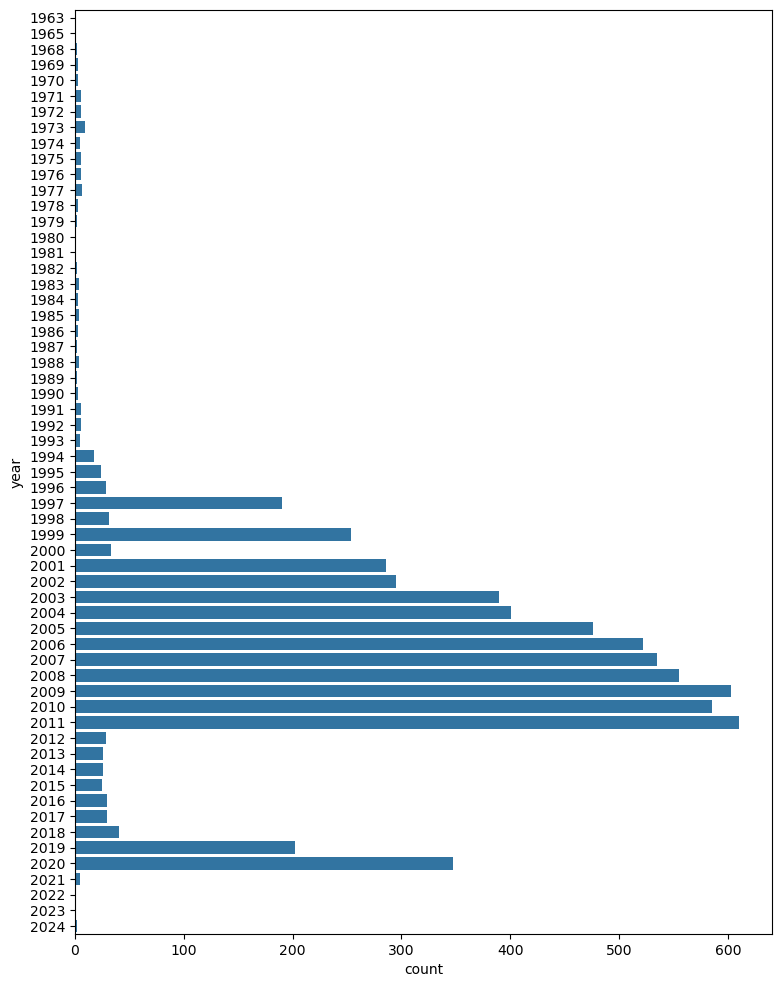

In [184]:
plt.figure(figsize=(9,12))
sns.countplot(data=df, y='year')

# **Statistics**

In [3]:
# import the df
df = pd.read_csv('Datasets/df_rock_ratings.csv')
df.shape 

(12059, 10)

In [10]:
df.artist.nunique()

5095

In [4]:
# average number of votes
np.mean(df['votes'])

199.27423501119495

<Axes: xlabel='rating', ylabel='Count'>

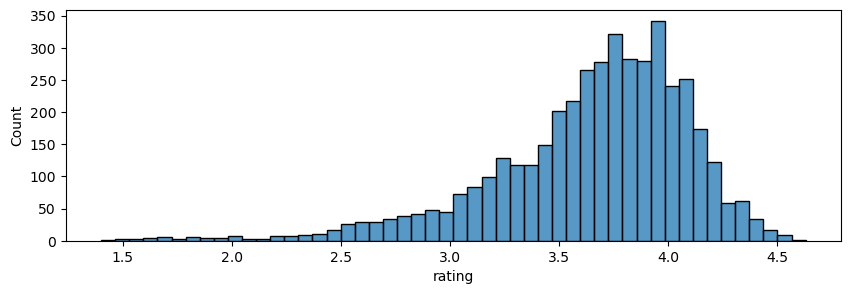

In [5]:
plt.figure(figsize=(10,3))
sns.histplot(data=df[df['votes']>100], x='rating')

<Axes: xlabel='votes', ylabel='Count'>

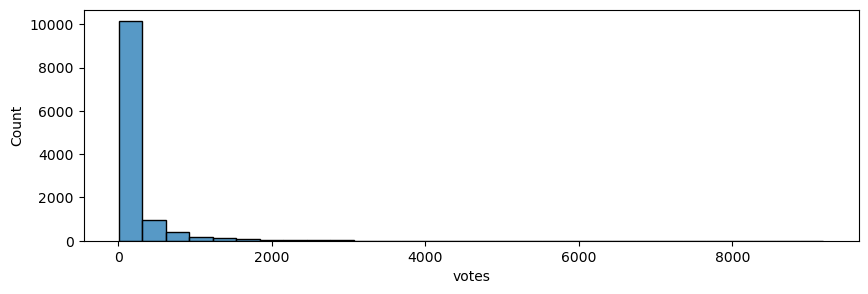

In [6]:
plt.figure(figsize=(10,3))
sns.histplot(data=df, x='votes', bins=30)

In [17]:
df[df['votes']>=20].shape

(9380, 10)

In [20]:
df[df['votes']>=20].artist.nunique()

3823

In [44]:
votes = 20

print(f"{df[df['votes']>=votes].shape[0]} of {df.shape[0]} albums have more than {votes} votes")
print(f"This represents {round(df[df['votes']>=votes].shape[0] / df.shape[0] *100, 2)} % of the albums")

9380 of 12059 albums have more than 20 votes
This represents 77.78 % of the albums


In [45]:
df_rock_ratings_20 = df[df['votes']>=20]
df_rock_ratings_20.shape

(9380, 10)

In [46]:
df_rock_ratings_20.head()

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
0,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,"['Indie Rock', 'Alternative Rock']",US,"El Paso, Texas based band. Formed in 2001 afte..."
1,2003,Muse,Absolution,3.99,4411,52.18,14,['Alternative Rock'],Europe,"Muse are an English rock band from Teignmouth,..."
2,1999,Muse,Showbiz,3.50,2181,49.65,12,"['Alternative Rock', 'Prog Rock']",UK,"Muse are an English rock band from Teignmouth,..."
3,2002,Finch,What It Is to Burn,3.69,864,61.18,13,"['Emo', 'Post-Hardcore', 'Alternative Rock']",US,"Finch is a post-hardcore band from Temecula, C..."
4,2002,Transplants,Transplants,3.35,198,45.23,12,['Punk'],US,"Punk rock/rap rock band Los Angeles, CA, Unite..."


In [47]:
df_rock_ratings_20.to_csv('Datasets/df_rock_ratings_20.csv', index=False)